# Fruit and Vegetable Identifier
Vorlesung Neue Konzepte -- Machine Learning

Dozentin: Anna Minges

Projektgruppe:
* Velichka Popp
* Jeannine Bertrand
* Jan Eger
* Timo Scheuermann
* Nicolas Fürhaupter

Wir haben ein eigenes [Dataset](https://www.kaggle.com/moohsassin/fruits-vegetables-wo-360) zum Trainieren dieses Modells erstellt.

Ziel dieses Projektes anhand von Bildern von Früchten und/oder Gemüse diese zu identifizieren. Dazu verwenden wir ein Convolutional Neural Network.

Link zu unserer Anwendungsseite: https://fvi.timos.design

## Preparations

### Imports and installations

In [ ]:
# general imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot graphs to display results and infromation
import os # class for file system
import json
import shutil
import tensorflow
import itertools

# imports for machine learning
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

!pip install kaggle # install kaggle package to download dataset
!pip install split-folders
import splitfolders

### Organize folders for data

In [ ]:
# Create a new directory
base_dir = 'base_dir'

os.mkdir(base_dir)

### Download Dataset
Download of the dataset via kaggle module and API token file which is created in this code

In [ ]:
# define and save kaggle token to download dataset off of kaggle
# valid kaggle token has to be entered
token = {"username":"xxx","key":"xxx"}
with open('kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download and unzip kaggle datast
!mkdir input # create directory for input
!kaggle datasets download moohsassin/fruits-vegetables-wo-360 -p input # download dataset .zip
!unzip -o input/fruits-vegetables-wo-360.zip -d input # unpack .zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: input/dataSetML/tomatoes/tomato (3818).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3819).jpg  
  inflating: input/dataSetML/tomatoes/tomato (382).jpg  
  inflating: input/dataSetML/tomatoes/tomato (382).png  
  inflating: input/dataSetML/tomatoes/tomato (3820).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3821).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3822).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3823).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3824).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3825).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3826).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3827).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3828).jpg  
  inflating: input/dataSetML/tomatoes/tomato (3829).jpg  
  inflating: input/dataSetML/tomatoes/tomato (383).jpg  
  inflating: input/dataSetML/tomatoes/tomato (383).png  
  inflati

In [ ]:
# remove mango folder from dataset
!rm -r "input/dataSetML/mango"
!rm -r "input/dataSetML/cauliflower"
!rm -r "input/dataSetML/cherry"
!rm -r "input/dataSetML/corn"
!rm -r "input/dataSetML/guava"
!rm -r "input/dataSetML/peach"
!rm -r "input/dataSetML/pitaya"
!rm -r "input/dataSetML/raspberry"

### Split data
Data is split into three directories: training, validation and test. Files in directories are shuffled.

In [ ]:
splitfolders.ratio('input/dataSetML', output="base_dir", seed=1337, ratio=(.72, 0.23,0.05))

Copying files: 60558 files [01:46, 568.36 files/s]


### How many pictures are in the directories?

In [ ]:
# print number of files in every directory
for kind in os.listdir('base_dir'):
  kind_dir = 'base_dir/' + kind
  for dir in os.listdir(kind_dir):
    temp_dir = kind_dir + '/' + dir
    print(dir, kind, ': ', len(os.listdir(temp_dir)))

potato val :  414
apple val :  1582
plum val :  1054
lime val :  10
kiwi val :  959
eggplant val :  143
fig val :  215
bellpepper val :  759
grape val :  166
watermelon val :  145
blueberry val :  295
tomatoes val :  2066
carambola val :  629
pear val :  2078
onion val :  410
brogle val :  103
banana val :  1137
ginger val :  91
orange val :  1207
strawberry val :  234
sweetpotato val :  138
lemon val :  82
potato test :  92
apple test :  345
plum test :  230
lime test :  4
kiwi test :  210
eggplant test :  32
fig test :  48
bellpepper test :  167
grape test :  37
watermelon test :  32
blueberry test :  65
tomatoes test :  451
carambola test :  138
pear test :  453
onion test :  90
brogle test :  24
banana test :  248
ginger test :  20
orange test :  264
strawberry test :  52
sweetpotato test :  30
lemon test :  19
potato train :  1298
apple train :  4952
plum train :  3301
lime train :  33
kiwi train :  3004
eggplant train :  449
fig train :  673
bellpepper train :  2378
grape train :

### Data augmentation
Original dataset is replaced by augmented dataset. Augmented dataset contains images which are shifted, rotated, zoomed and flipped. Files are augmented until amount of files in directory reaches about 8,000.

In [ ]:
# only training directories are augmented
class_list = os.listdir('base_dir/train')

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Get current class of for loop
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train/' + img_class)

    # Copy images from the class train dir to the img_dir
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
    
    

    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 8000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1298 images belonging to 1 classes.
Found 4952 images belonging to 1 classes.
Found 3301 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Found 3004 images belonging to 1 classes.
Found 449 images belonging to 1 classes.
Found 673 images belonging to 1 classes.
Found 2378 images belonging to 1 classes.
Found 522 images belonging to 1 classes.
Found 455 images belonging to 1 classes.
Found 923 images belonging to 1 classes.
Found 6469 images belonging to 1 classes.
Found 1969 images belonging to 1 classes.
Found 6508 images belonging to 1 classes.
Found 1284 images belonging to 1 classes.
Found 324 images belonging to 1 classes.
Found 3561 images belonging to 1 classes.
Found 285 images belonging to 1 classes.
Found 3780 images belonging to 1 classes.
Found 732 images belonging to 1 classes.
Found 432 images belonging to 1 classes.
Found 258 images belonging to 1 classes.


### How many pictures in directories after augmentation?

In [ ]:
# observe difference in amount of files in training classes
for kind in os.listdir('base_dir'):
  kind_dir = 'base_dir/' + kind
  for dir in os.listdir(kind_dir):
    temp_dir = kind_dir + '/' + dir
    print(dir, kind, ': ', len(os.listdir(temp_dir)))

potato val :  414
apple val :  1582
plum val :  1054
lime val :  10
kiwi val :  959
eggplant val :  143
fig val :  215
bellpepper val :  759
grape val :  166
watermelon val :  145
blueberry val :  295
tomatoes val :  2066
carambola val :  629
pear val :  2078
onion val :  410
brogle val :  103
banana val :  1137
ginger val :  91
orange val :  1207
strawberry val :  234
sweetpotato val :  138
lemon val :  82
potato test :  92
apple test :  345
plum test :  230
lime test :  4
kiwi test :  210
eggplant test :  32
fig test :  48
bellpepper test :  167
grape test :  37
watermelon test :  32
blueberry test :  65
tomatoes test :  451
carambola test :  138
pear test :  453
onion test :  90
brogle test :  24
banana test :  248
ginger test :  20
orange test :  264
strawberry test :  52
sweetpotato test :  30
lemon test :  19
potato train :  8038
apple train :  8002
plum train :  7952
lime train :  5313
kiwi train :  7958
eggplant train :  8033
fig train :  7753
bellpepper train :  7984
grape tra

## Build model

### Set different parameters for training

* num_train_samples --> how many training images are used
* num_val_samples --> how many validation images are used
* train_batch_size --> size of image batches that are used for training
* val_batch_size --> size of image batches that are used for validation
* image_size --> size of images used in training and validation


In [ ]:
# set train and validation paths
train_path = 'base_dir/train'
valid_path = 'base_dir/val'

num_train_samples = 0
num_val_samples = 0

# compute number of train images
for train_class in os.listdir(train_path):
  train_class_path = train_path + '/' + train_class
  num_train_samples = num_train_samples + len(os.listdir(train_class_path))

print(num_train_samples)

# compute number of validation images
for val_class in os.listdir(valid_path):
  val_class_path = valid_path + '/' + val_class
  num_val_samples = num_val_samples + len(os.listdir(val_class_path))

print(num_val_samples)

# set size of train and validation batch and set images size
train_batch_size = 10
val_batch_size = 10
image_size = 224

# compute amount of steps taken in each epoch
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

169428
13917


### Turn dataset into train, validation and test batches
Turn current dataset into batches which are suitable for neural network to train on

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 169428 images belonging to 22 classes.
Found 13917 images belonging to 22 classes.
Found 13917 images belonging to 22 classes.


### Download mobilenet


In [ ]:
# create a copy of a mobilenet model
# pre-trained neural network - classification of pictures

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


### Create model architecture

In [ ]:
# Exclude the last 5 layers of the above model.
x = mobile.layers[-6].output

# Create a new dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(len(os.listdir('base_dir/train')), activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

### Define retrainable layers

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 25 layers in the new model.
# The last 25 layers of the model will be trained.

for layer in model.layers[:-25]:
    layer.trainable = False

### Define an accuracy metric for validation
categorical_accuracy = how often does prediction match correct label

In [ ]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])

## Train model

### Actual fitting

In [ ]:
# set filepath for model
filepath = "model.h5"

# checkpoints and callbacks are used to save model during training in case of unexpected stopping of training
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

# use reduce learning rate when metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

# train the model
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
16943/16943 [==============================] - 614s 34ms/step - loss: 0.5938 - categorical_accuracy: 0.8348 - val_loss: 0.1097 - val_categorical_accuracy: 0.9636

Epoch 00001: categorical_accuracy improved from -inf to 0.91356, saving model to model.h5
Epoch 2/10
16943/16943 [==============================] - 570s 34ms/step - loss: 0.1080 - categorical_accuracy: 0.9677 - val_loss: 0.0590 - val_categorical_accuracy: 0.9812

Epoch 00002: categorical_accuracy improved from 0.91356 to 0.97071, saving model to model.h5
Epoch 3/10
16943/16943 [==============================] - 528s 31ms/step - loss: 0.0765 - categorical_accuracy: 0.9769 - val_loss: 0.0433 - val_categorical_accuracy: 0.9866

Epoch 00003: categorical_accuracy improved from 0.97071 to 0.97787, saving model to model.h5
Epoch 4/10
16943/16943 [==============================] - 504s 30ms/step - loss: 0.0600 - categorical_accuracy: 0.9821 - val_loss: 0.0329 - val_categorical_accuracy: 0.9890

Epoch 00004: categorical_acc

### Get different metrics

In [ ]:
# Here the the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, steps=num_val_samples)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.030980287119746208
val_cat_acc: 0.9900840520858765


## Test model

### Review model training

loss: [0.2954305410385132, 0.09732383489608765, 0.07284557819366455, 0.060381170362234116, 0.054852601140737534, 0.05171080678701401, 0.047563839703798294, 0.04520131275057793, 0.04188806191086769, 0.03993920981884003]
val_loss: [0.10968056321144104, 0.05896354466676712, 0.04329311475157738, 0.03294235095381737, 0.04293697327375412, 0.03218811750411987, 0.04166390001773834, 0.03750786930322647, 0.02987484261393547, 0.03098047338426113]
acc: [0.9135562181472778, 0.9707072973251343, 0.9778726100921631, 0.9817444682121277, 0.9837098717689514, 0.9848549365997314, 0.9860589504241943, 0.9866964221000671, 0.9878414273262024, 0.9883313179016113]
val_acc: [0.9636415839195251, 0.981174111366272, 0.9866350293159485, 0.9890062808990479, 0.9857009649276733, 0.989940345287323, 0.9891499876976013, 0.9902277588844299, 0.9915211796760559, 0.9900840520858765]


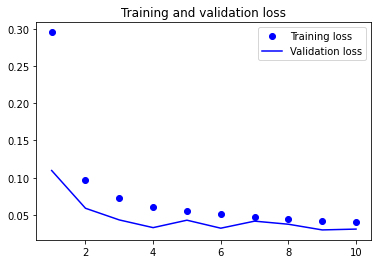

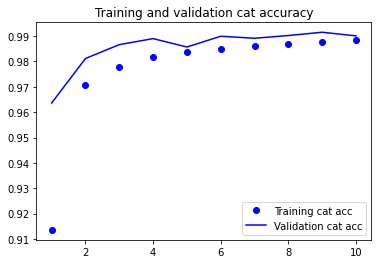

In [ ]:
# display the loss and accuracy curves

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print('loss:', loss)
print('val_loss:', val_loss)

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

print('acc:', acc)
print('val_acc:', val_acc)

plt.show()

### Save modal as .h5-file for later use

In [ ]:
model.save("model.h5") # save fitted model

### Print confusion matrix

In [ ]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [ ]:
# make a prediction using the test batches
predictions = model.predict_generator(test_batches, steps=num_val_samples, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


13917/13917 [==============================] - 83s 6ms/step


In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(35, 35))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'apple': 0,
 'banana': 1,
 'bellpepper': 2,
 'blueberry': 3,
 'brogle': 4,
 'carambola': 5,
 'eggplant': 6,
 'fig': 7,
 'ginger': 8,
 'grape': 9,
 'kiwi': 10,
 'lemon': 11,
 'lime': 12,
 'onion': 13,
 'orange': 14,
 'pear': 15,
 'plum': 16,
 'potato': 17,
 'strawberry': 18,
 'sweetpotato': 19,
 'tomatoes': 20,
 'watermelon': 21}

Normalized confusion matrix
[[9.84829330e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.32111252e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.89633375e-03 6.32111252e-04 1.26422250e-03
  1.26422250e-03 0.00000000e+00 5.68900126e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.79266751e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.96047431e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0000

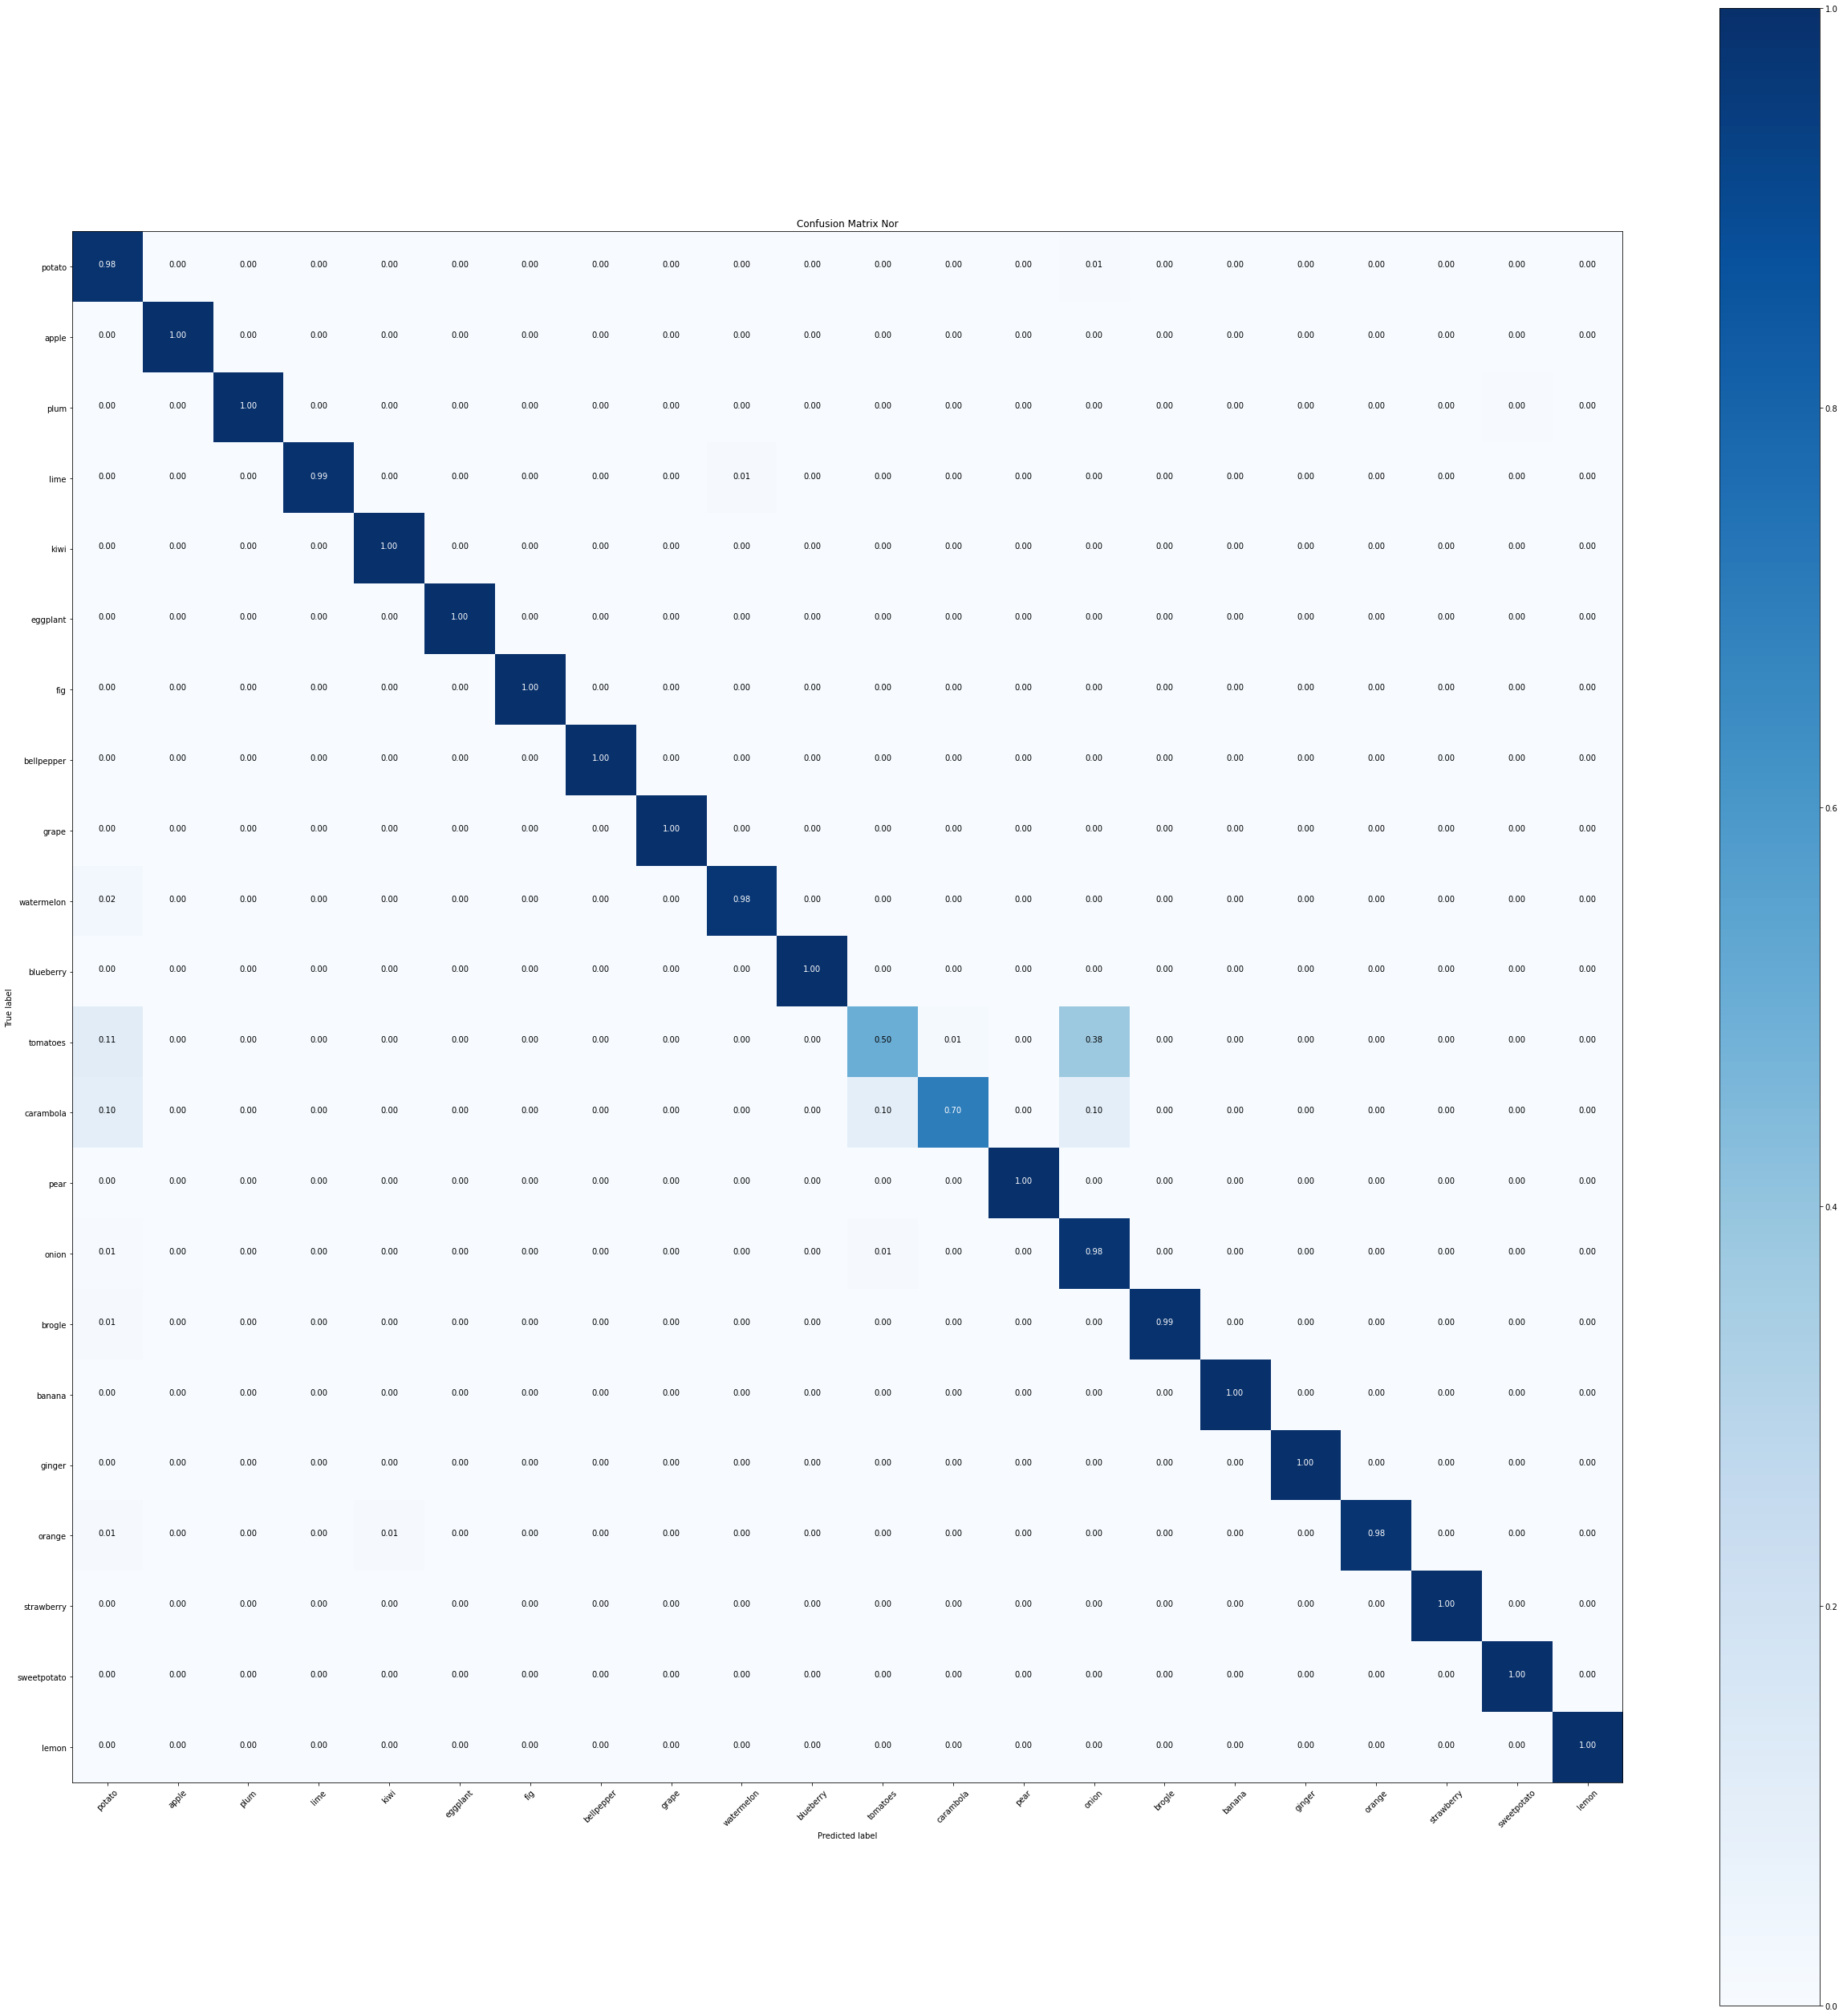

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = os.listdir('base_dir/train')

#plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Confusion Matrix Nor')

### Print classification report

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [ ]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      potato       0.97      0.98      0.98      1582
       apple       1.00      1.00      1.00      1137
        plum       1.00      1.00      1.00       759
        lime       1.00      0.99      0.99       295
        kiwi       0.97      1.00      0.99       103
    eggplant       1.00      1.00      1.00       629
         fig       0.99      1.00      1.00       143
  bellpepper       1.00      1.00      1.00       215
       grape       1.00      1.00      1.00        91
  watermelon       0.95      0.98      0.96       166
   blueberry       1.00      1.00      1.00       959
    tomatoes       0.72      0.50      0.59        82
   carambola       0.64      0.70      0.67        10
        pear       1.00      1.00      1.00       410
       onion       0.96      0.98      0.97      1207
      brogle       1.00      0.99      1.00      2078
      banana       1.00      1.00      1.00      1054
      ginger       1.00    

### Convert the Model from Keras to Tensorflow.js
Model as zip needed for frontend

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 112kB 11.6MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
!tensorflowjs_converter --input_format keras model.h5 SimpleModel/

2021-04-03 10:16:42.799066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
!mv model.h5 SimpleModel/
!zip -r TrainedModel.zip SimpleModel/

  adding: SimpleModel/ (stored 0%)
  adding: SimpleModel/group1-shard3of4.bin (deflated 7%)
  adding: SimpleModel/group1-shard1of4.bin (deflated 6%)
  adding: SimpleModel/group1-shard2of4.bin (deflated 6%)
  adding: SimpleModel/model.h5 (deflated 48%)
  adding: SimpleModel/group1-shard4of4.bin (deflated 7%)
  adding: SimpleModel/model.json (deflated 94%)


# Dokumentation

## Einleitung

Im Rahmen der Vorlesung "Neue Konzepte II - Machine Learning" entschieden wir uns, ein Convolutional Neural Network mittels Supervised Learning auf Klassifizierung zu trainieren. Als Anwendungsfall entschieden wir uns für Bilder von verschiedene Gemüse- und Obstsorten, da https://www.kaggle.com zu diesen bereits verschiedene Datensätze zur Verfügung stellt:


1.   https://www.kaggle.com/jorgebailon/fruits-vegetables
2.   https://www.kaggle.com/moltean/fruits
3.   https://www.kaggle.com/chrisfilo/fruit-recognition

Ziel ist es mittels Bilderkennung eine abgebildete Obst- oder Gemüsesorte zu identifizieren. Da das Modell jedoch nur Sorten richtig erkennen kann, mit denen es trainiert wurde, gilt es dies später bei der Auswahl der Testdaten zu beachten.




## Vorbereitung

### Code

Das Aufsetzen des Notebooks begann mit dem Import und der Installation der verschiedenen benötigten Module, wie beispielsweise die Algebraischen-Methoden, das Dataprocessing, das Darstellen der Matrizen und Metriken oder die Anbindung an Kaggle. Es wurde ein temporäres Directory erstellt und der Datensatz von Kaggle heruntergeladen und entpackt. Anschließend wurden der heruntergeladene Datensatz in verschiedene Basedirectories zum Trainieren, Validieren und Testen des Modells geteilt.

Zur Überprüfung ließen wir uns an dieser Stelle einmal die Anzahl der Bilder pro Ordner ausgeben. Da auffiel, dass die Anzahl der Bilder der einzelnen Obst- und Gemüsesorten sehr unterschiedlich und zu gering aufällt, werden diese über eine "Augementation" durch routieren, zoomen, spiegeln o.Ä. auf ca. 8.000 Bilder pro Frucht oder Gemüse erweitert. Nun konnten die Bilder des temporären Directorys in das normale Directory des Notebooks geladen und gelöscht werden. Zur erneuten Kontrolle ließen wir uns erneut die Ordnerstrukut mit Bilderanzahlen ausgeben.




### Modell

Zum Erstellen des Modells wurden zunächst die wichtigsten Parameter gesetzt oder berechnet, zusammengezählt, die verschiedenen Größen der Batches (Paket von Bildern) der Klassen und die Anzahl der Epochen zum Trainieren festgelegt. Im ImageDataGenerator wurden die Batches für das Training und die Validation erstellt, die später in das neuronale Netz eingebunden werden. Ebenfall wurden an dieser Stelle die Testbatches erstellt, die anschließend kontrollieren, wie das Modell performt.

Bevor es anschließend an das Training des Modells gehen kann, wurde an dieser Stelle festgelegt, wie viele Schichten des Modells neu trainiert werden und welche Metriken dieses lernen soll. Mithilfe dieser Metriken soll abgeschätzt werden können, wie gut das Modell lernt und wie es das Training anpasst.


### Dataset

Nun ging es an das Bereinigen und Zusammenfügen der Datensätze.

Es viel auf, dass die Bilder in Datensatz 1 teilweise nicht für unseren Fall geeignet und teilweise fehlerhaft platziert wurden. Bilder, auf denene verschiedene Obst- oder Gemüsesorten plaziert waren, sowie im Vordergrund andere Gegenstände darstellten, wurden für unseren Anwendungsfall als ungeeignet angesehen. Dies stellt einen hohen Bereinigungsaufwand dar, da alle Bilder kontrolliert und gegebenenfalls gelöscht oder in einen anderen Ordener verschoben werden mussten.

Datensatz 2 stellte eine große Auswahl an Obst- und Gemüsesorten zur Verfügung, sowie ein hohe Anzahl an Bildern pro Sorte. Der Datensatz beinhaltete 365° Bilder der einzelnen Obst- und Gemüsesorten, sowie verschiedene Arten (bspw. rote, gelbe, grüne Paprika) dieser. Dadurch, dass dieser Datensatz jedoch auch eine Unterscheidung zwischen beispielsweise Mandarinen, Apfelsinen und Clementinen macht, wurden diese zur Vereinfachung als "eine Frucht" zusammengefasst.

Auch im dritten Datensatz mussten verschiedene Arten einer Obst- oder Gemüsesorte zusammen gefasst werden.

Nun wurden die verschiedenen Datensätze in einen zusammengefasst und die einzelnen Obst- und Gemüsesorten-Bilder in eigenen Ordnern gespeichert. Diese Datei umfasste nun über 50 verschiedene Obst- und Gemüsesorten und brauchte als .zip-Datei ca. 6 GB Speicherplatz.

Dieser Datensatz wurde ebenfalls auf https://www.kaggle.com hochgeladen und in das Notebook eingebunden.

## Training und Test

### Code

#### Training

Zu Beginn wurde festgelegt an welcher Stelle das Modell und seine Checkpoints (wenn Verbindung abbricht, wird das Modell zwischengespeichert) gespeichert werden soll, sowie ein Heruntersetzen der Lernrate, falls sich das Modell nach einer gewissen Anzahl an Epochen nicht mehr verbessert.

Das Modell bagann mittels der Trainbatches über 10 Epochen (Trainingsdurchgänge des gesamten Modells) zu lernen, sein Erlerntes mithilfe der Validationbatches zu Validieren und an den Checkpoints zwischenzuspeichern. Jede Epoche umfasste 16943 Schritte und konnte am Ende ein Ergebis über die aktuelle Leistung des Modells liefern. Beendet wurde das Training mit der Ausgabe der Genauigkeit des Modells.


#### Test

Innerhalb des Tests wurde die Genauigkeit, sowie der Verlust dieser, über die Zeit innerhalb von Diagrammen dargestellt.
Das Modell speicherten wir als eine .h5-Datei.

Weiter testeten wir das Modell mithilfe der Testbatches, erstellten eine Konfusionsmatrix und einen Klassification-Report. 

Zu guter Letzt wandelten wir das Modell in eine Tensorflow.js-Datei um, um diese in unsere Anwendung https://fvi.timos.design/ einbinden zu können.

### Dataset und Output

Das Modell wurde in 10 Epochen über circa 2 Stunden trainiert und war nun bereit zum Test. 
Um das Testen und die spätere Anwendung zu vereinfachen wurde eine übersichtliche UI um die Anwendung gebaut. Nachdem das Testbild hochgeladen wurde, analysiert das Modell, zu welcher Obst- oder Gemüseklasse die abgebildete Frucht/ das abgebildete Gemüse gehört. Nun gibt das Modell seinem Anwender seine Erkenntnis, sowie die Prozentzahl wie sicher es sich mit seiner Aussage ist. Als kleiner Bonus wurde eine Nährwerteangabe, sowie ein kleiner "Funfact" zur Gemüse- oder Obstsorte ergänzt.

## Auffälligkeiten und Anpassungen

Die ersten Testdurchläufe mit einfachen Apfel- und Zitronenbildern liefen gut und das Modell konnte die Frucht erkennen. Sobald jedoch ein etwas undeutlicheres Bild, ein Bild von "unperfektem" Obst oder Gemüse oder ein Bild einer "ausgefallenen" Obst- oder Gemüsesorte genommen wurde, erkannte das Modell nicht die richtige Frucht/das richitge Gemüse. 

Unsere Annahme war, dass die einzelnen Klassen nicht mit dem gleichen Umfang an Bilder gefüllt und diese teilweise nicht "abwechslungsreich" genug waren. Wir schauten die einzelnen Ordner-Klassen durch und erkannten, dass wir mit unserer annahme richtig lagen. Besonders die Bilder aus Datensatz 2 lieferten durch die makellose 360° Abbildung "perfekter" Obst- und Gemüsesorten kaum einen Mehrwert zu unserem Trainingsmodell, weshalb diese aus "problematischen" Ordnern entfernt wurden. Außerdem beinhalteten manche Klassen nur ca. 20 Bilder, während andere über 4.000 Bilder beinhalteten.

Also wurde der Datensatz erneut bereinigt. Die Bilder aus Datensatz 2 wurden wieder entfernt und die Klassen mit einem geringen Bildumfang ebenfalls. Somit beinhaltete unser Modell anschließend "nur" noch ca. 25 Klassen, denen die Testdaten zugeordnet werden können.

Außerdem wurde durch Ausprobieren die Ratio zwischen Trainings-, Validations- und Testdaten in verschiedenen Durchläufen verändert. Das beste Ergebnis wurde durch die aktuelle Aufteilung von 72/23/5 erzielt.

## Ergebnis und Interpretation

Das Training des Modells nahm sehr viel Zeit in Anspruch und forderte eine hohe GPU-Auslastung. Ein Problem beim Erstellen dieses Modells lässt sich also in der zur Verfüung stehenden Leistung finden. Die verwendete Hardware ist limitiert und somit ein längeres und umffangreicheres Training nicht möglich.

Wie in den Ergebnissen des Testings zu sehen ist, ist die Accuracy des Modells sehr hoch. Auch die Konfusionsmatrix und der Classificationreport stellen ein super Ergebnis dar. Testet man das Modell jedoch mit Alltagsbildern fällt auf, dass das Modell weit keine 99% Genauigkeit ereicht. Da wir für unser Modell Trainings-, Validation- und Testbilder aus dem gleichen Datensatz nehmen, scheint unser Modell "auswendig zu lernen". die verwendeten Bilder zeigen das Obst und Gemüse hauptsächlich in perfekten Formen und Verhältnissen. Datensatz 3 beispielsweise stellt einen Großteil der Bilder bereit, auf denen das Obst oder Gemüse unter perfekten Lichtverhältnissen, ohne Ablenkungen und unter verschiedener Anordnung abgelichtet sind. Perfekt wäre an dieser Stelle ein großer Datensatz mit Bildern aus dem Alltag, um das Modell zu verbessern. Aktuell leidet unser Fruit & Vegetable Identifier jedoch unter Overfitting, da das Modell an die Trainingsdaten angepasst ist.

Würden wenigstens die benutzten Testdaten durch Alltagsbilder ausgetauscht werden, würde das Modell eine geringere Accuracy erzielen, die jedoch eine höhere Aussagekraft hätte als die aktuelle. 




### Lessons-Learned

Würden wir das Projekt von Vorne beginnen, würde wir von Anfang an ein größeres Augenmerk auf die Datengrundlage legen. Diese sollte umfangreicher sein und unterschiedliche Situationen abbilden. Auch der Anwendungsfall sollte besser an das Modell angepasst werden und mit der gegebenen Datengrundlage möglich sein. Des Weiteren würden wir versuchen unser Modell mit weniger Klassen trainieren, die jedoch mehr variierte Bilder beinhalten. 
